# MWE of ResNet50 with zennit

Demo capabilities of zennit with ResNet to potentially integrate it into the experiments.

Steps:

1. ~~Reproduce snippet from [GitHub](https://github.com/chr5tphr/zennit/issues/76#issuecomment-992581003)~~
1. ~~Add VGG16 cannonizer to snippet~~
1. Try ResNet50, see [official example](https://github.com/chr5tphr/zennit/blob/e191d6cd9d1d4edc19f0b165006488dd39c36d9a/share/example/feed_forward.py)
1. Use a different image with ResNet50
1. Rename variables to `_nchw` format

Code imported from [GitHub](https://github.com/chr5tphr/zennit/issues/76#issuecomment-992581003)

[(['features.0'], <zennit.rules.ZBox at 0x12f573850>),
 (['features.2',
   'features.5',
   'features.7',
   'features.10',
   'features.12',
   'features.14'],
  <zennit.rules.Gamma at 0x12f5a44c0>),
 (['features.17',
   'features.19',
   'features.21',
   'features.24',
   'features.26',
   'features.28'],
  <__main__.GMontavonEpsilon at 0x12f5a4fa0>),
 (['classifier.0', 'classifier.3', 'classifier.6'],
  <zennit.rules.Epsilon at 0x12f5a4f40>)]

0.24230274558067322


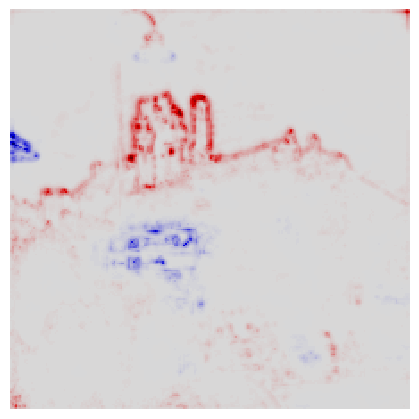

In [1]:
import cv2
import numpy
import torch
from torch.nn import AvgPool2d, Conv2d, Linear
from torchvision.models import vgg16
from zennit.composites import NameMapComposite
from zennit.core import BasicHook, collect_leaves, stabilize
from zennit.rules import Epsilon, Gamma, ZBox
from zennit.torchvision import VGGCanonizer

from lrp.core import LRP


# the LRP-Epsilon from the tutorial
class GMontavonEpsilon(BasicHook):
    def __init__(self, stabilize_epsilon=1e-6, epsilon=0.25):
        super().__init__(
            input_modifiers=[lambda input: input],
            param_modifiers=[lambda param, _: param],
            output_modifiers=[lambda output: output],
            gradient_mapper=(lambda out_grad, outputs: out_grad / stabilize(
                outputs[0] + epsilon * (outputs[0] ** 2).mean() ** .5, stabilize_epsilon)),
            reducer=(lambda inputs, gradients: inputs[0] * gradients[0])
        )

# use the gpu if requested and available, else use the cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


class BatchNormalize:
    def __init__(self, mean, std, device=None):
        self.mean = torch.tensor(mean, device=device)[None, :, None, None]
        self.std = torch.tensor(std, device=device)[None, :, None, None]

    def __call__(self, tensor):
        return (tensor - self.mean) / self.std


# mean and std of ILSVRC2012 as computed for the torchvision models
norm_fn = BatchNormalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225), device=device)
batch_size = 1
# the maximal input shape, needed for the ZBox rule
shape = (batch_size, 3, 224, 224)

# the highest and lowest pixel values for the ZBox rule
low = norm_fn(torch.zeros(*shape, device=device))
high = norm_fn(torch.ones(*shape, device=device))


model = vgg16(pretrained=True)
model.eval()

# only these get rules, linear layers will be attributed by the gradient alone
# target_types = (Conv2d, AvgPool2d)
target_types = (Conv2d, AvgPool2d, Linear)
# lookup module -> name
child_name = {module: name for name, module in model.named_modules()}
# the layers in sequential order without any containers etc.
layers = list(enumerate(collect_leaves(model)))

# list of tuples [([names..], rule)] as used by NameMapComposite
name_map = [
    ([child_name[module] for n, module in layers if n == 0 and isinstance(module, target_types)], ZBox(low=low, high=high)),
    ([child_name[module] for n, module in layers if 1 <= n <= 16 and isinstance(module, target_types)], Gamma(0.25)),
    ([child_name[module] for n, module in layers if 17 <= n <= 30 and isinstance(module, target_types)], GMontavonEpsilon(stabilize_epsilon=0, epsilon=0.25)),
    ([child_name[module] for n, module in layers if 31 <= n and isinstance(module, target_types)], Epsilon(0)),
]

# look at the name_map and you will see that there is no layer for which the last condition holds
display(name_map)

# create the composite from the name map
composite = NameMapComposite(name_map, canonizers=[VGGCanonizer()])

R = None
with composite.context(model) as modified_model:
    # compute attribution
    # Returns a numpy array in BGR color space, not RGB
    img = cv2.imread('../../../data/castle.jpg')

    # Convert from BGR to RGB color space
    img = img[..., ::-1]

    # img.shape is (224, 224, 3), where 3 corresponds to RGB channels
    # Divide by 255 (max. RGB value) to normalize pixel values to [0,1]
    img = img/255.0
    
    data = norm_fn(
        torch.FloatTensor(
            img[numpy.newaxis].transpose([0, 3, 1, 2])*1
        )
    )
    data.requires_grad = True

    output = modified_model(data)
    output[0].max().backward()

    # print absolute sum of attribution
    print(data.grad.abs().sum().item())

    R = data.grad

    LRP.heatmap(R)